In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import seaborn as sns
import matplotlib.pyplot as plt

This notebook contains an elementary analysis of 'train.csv' and rule based baseline. I will further develop it during the competition.
Here I analyze the distributions of different features, generate aggregeted features based on 90% of historical data and then train the model on the rest 10%.

My other materials on this competition:
- Double validation (against target leakage): https://www.kaggle.com/ilialar/riiid-5-folds-double-validation
- Dataset with pretrained models and feature generators: https://www.kaggle.com/ilialar/riiid-models

# Train data

The `train.csv` file is too large for kaggle kernel. You will get a memory error if you try to load it all without specifying types. We will ignore some columns for now to save RAM and load only 10M rows.

In [2]:
data_types_dict = {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
#     'task_container_id': 'int16',
#     'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float16',
    'prior_question_had_explanation': 'boolean'
}

In [3]:
train_df = pd.read_csv('~/kaggle/input/riiid-test-answer-prediction/train.csv', 
                       nrows=10**7,
                       usecols = data_types_dict.keys(),
                       dtype=data_types_dict, 
                       index_col = 0)

/Users/danh/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Let's look at the data and main columns properties:

In [4]:
train_df.tail(10)

,timestamp,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,
9999990,645945001,216747867,6058,0,0,24000.0,True
9999991,646017531,216747867,8546,0,0,19008.0,True
9999992,646043267,216747867,5481,0,1,51008.0,True
9999993,646078767,216747867,5267,0,0,6000.0,True
9999994,646161049,216747867,6431,0,0,16000.0,True
9999995,646228695,216747867,8805,0,1,23008.0,True
9999996,646321314,216747867,5708,0,0,13000.0,True
9999997,646393443,216747867,5434,0,0,inf,True
9999998,646445632,216747867,6429,0,1,36992.0,True


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000000 entries, 0 to 9999999
Data columns (total 7 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   answered_correctly              int8   
 5   prior_question_elapsed_time     float16
 6   prior_question_had_explanation  boolean
dtypes: boolean(1), float16(1), int16(1), int32(1), int64(1), int8(2)
memory usage: 267.0 MB


In [6]:
train_df.describe()

,timestamp,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time
count,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,9765216.0
mean,7.546528e+09,1.079943e+08,5.209509e+03,1.953960e-02,6.262029e-01,NaN
std,1.141381e+10,6.311024e+07,3.867783e+03,1.384117e-01,5.226395e-01,NaN
min,0.000000e+00,1.150000e+02,0.000000e+00,0.000000e+00,-1.000000e+00,0.0
25%,5.109600e+08,5.398177e+07,2.059000e+03,0.000000e+00,0.000000e+00,16000.0
50%,2.612310e+09,1.067638e+08,5.016000e+03,0.000000e+00,1.000000e+00,20992.0
75%,9.751909e+09,1.630735e+08,7.402000e+03,0.000000e+00,1.000000e+00,29664.0
max,8.470816e+10,2.167479e+08,3.273600e+04,1.000000e+00,1.000000e+00,inf


Let's look at some columns more precisely.

## timestamp

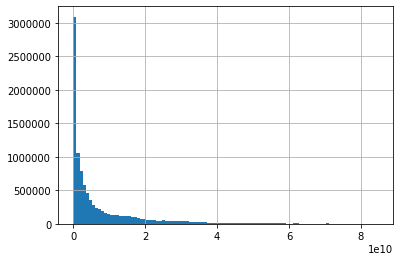

In [7]:
train_df['timestamp'].hist(bins = 100)

`timestamp` represents the time from the first user interaction to the current one. It is expected that the distribution looks like this.

In [8]:
grouped_by_user_df = train_df.groupby('user_id')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82e457cad0>]],
      dtype=object)

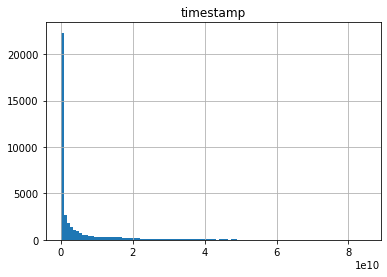

In [9]:
grouped_by_user_df.agg({'timestamp': 'max'}).hist(bins = 100)

In [22]:
g1 = grouped_by_user_df.get_group(115)

In [23]:
g1

,timestamp,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,
0,0,115,5692,0,1,NaN,<NA>
1,56943,115,5716,0,1,36992.0,False
2,118363,115,128,0,1,55008.0,False
3,131167,115,7860,0,1,19008.0,False
4,137965,115,7922,0,1,11000.0,False
5,157063,115,156,0,1,5000.0,False
6,176092,115,51,0,1,16992.0,False
7,194190,115,50,0,1,16992.0,False
8,212463,115,7896,0,1,16000.0,False


In [18]:
grouped_by_user_df.head()

,timestamp,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,
0,0,115,5692,0,1,NaN,<NA>
1,56943,115,5716,0,1,36992.0,False
2,118363,115,128,0,1,55008.0,False
3,131167,115,7860,0,1,19008.0,False
4,137965,115,7922,0,1,11000.0,False
...,...,...,...,...,...,...,...
9998958,0,216747867,4167,0,1,NaN,<NA>
9998959,25393,216747867,8290,0,1,20992.0,False
9998960,78258,216747867,4706,0,0,20000.0,False


## Answered correctly

In [13]:
(train_df['answered_correctly']==-1).mean()

0.0195396

~2% of activities are lectures, we should exclude them for answers analysis.

In [14]:
train_questions_only_df = train_df[train_df['answered_correctly']!=-1]
train_questions_only_df['answered_correctly'].mean()

0.6586115053703342

On average users answer ~66% questions correctly. Let's look how it is different from user to user.

### Answers by users

In [15]:
grouped_by_user_df = train_questions_only_df.groupby('user_id')

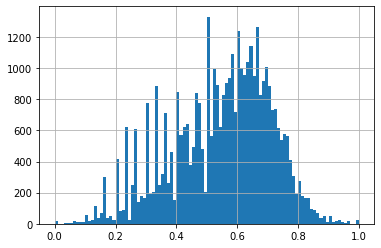

In [16]:
user_answers_df = grouped_by_user_df.agg({'answered_correctly': ['mean', 'count'] })

user_answers_df[('answered_correctly','mean')].hist(bins = 100)

Look's noisy, let's clear it a little bit

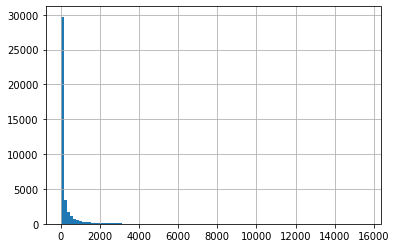

In [17]:
user_answers_df[('answered_correctly','count')].hist(bins = 100)

In [18]:
(user_answers_df[('answered_correctly','count')]< 50).mean()

0.5425539996454889

54% of users answered less than 50 questions. Let's divide all users into novices and active users.

In [19]:
user_answers_df[user_answers_df[('answered_correctly','count')]< 50][('answered_correctly','mean')].mean()

0.4807905823433236

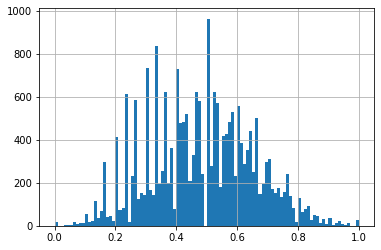

In [20]:
user_answers_df[user_answers_df[('answered_correctly','count')]< 50][('answered_correctly','mean')].hist(bins = 100)

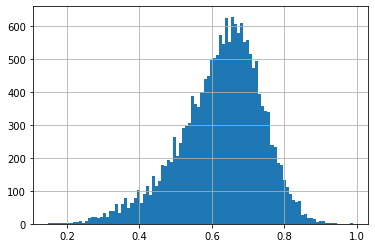

In [21]:
user_answers_df[user_answers_df[('answered_correctly','count')] >= 50][('answered_correctly','mean')].hist(bins = 100)

In [22]:
user_answers_df[user_answers_df[('answered_correctly','count')] >= 50][('answered_correctly','mean')].mean()

0.6237197253011861

We can see that active users do much better than novices. But anyway average user score is lower than the overall % of correct answers. It means heavy users have even better scores. Let's look at them.

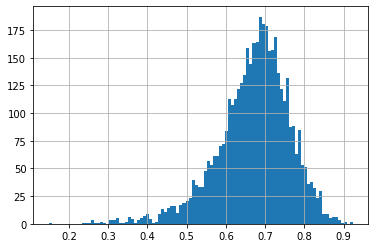

In [23]:
user_answers_df[user_answers_df[('answered_correctly','count')] >= 500][('answered_correctly','mean')].hist(bins = 100)

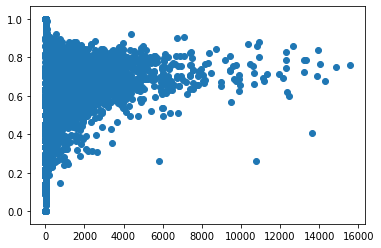

In [24]:
plt.scatter(x = user_answers_df[('answered_correctly','count')], y=user_answers_df[ ('answered_correctly','mean')])

Timestamp, the average score for the active user, and the number of questions answered can be useful for baseline.

### Answers by content

In [25]:
grouped_by_content_df = train_questions_only_df.groupby('content_id')

In [26]:
content_answers_df = grouped_by_content_df.agg({'answered_correctly': ['mean', 'count'] })

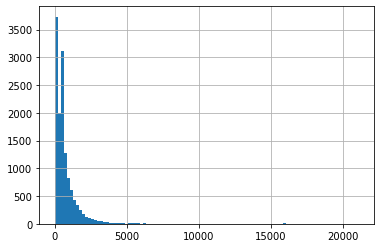

In [27]:
content_answers_df[('answered_correctly','count')].hist(bins = 100)

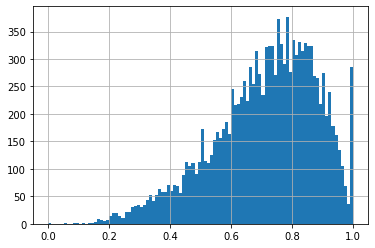

In [28]:
content_answers_df[('answered_correctly','mean')].hist(bins = 100)

Different questions have different popularity and complexity, and it can also be used in the baseline.

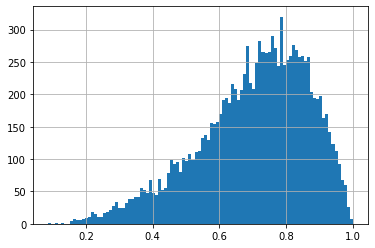

In [29]:
content_answers_df[content_answers_df[('answered_correctly','count')]>50][('answered_correctly','mean')].hist(bins = 100)

# Questions.csv

Let's look into the `questions.csv` file

In [8]:
questions_df = pd.read_csv('~/kaggle/input/riiid-test-answer-prediction/questions.csv')

In [32]:
questions_df

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [33]:
print(f"There are {len(questions_df['part'].unique())} different parts")

There are 7 different parts


In [34]:
questions_df['tags'].values[-1]

'55'

In [35]:
unique_tags = set().union(*[y.split() for y in questions_df['tags'].astype(str).values])
print(f"There are {len(unique_tags)} different tags")

There are 189 different tags


In [36]:
(questions_df['question_id'] != questions_df['bundle_id']).mean()

0.277896916364712

We can create aggregated features using the data from this file as well.

# Baseline

Let's try to use discovered features and use them in model to predict the right answer probability.

In [3]:
train_df = pd.read_csv('~/kaggle/input/riiid-test-answer-prediction/train.csv',
                       usecols = data_types_dict.keys(),
                       dtype=data_types_dict, 
                       index_col = 0)

/Users/danh/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
features_part_df = train_df.iloc[:int(9 /10 * len(train_df))]
train_part_df = train_df.iloc[int(9 /10 * len(train_df)):]

In [5]:
train_questions_only_df = features_part_df[features_part_df['answered_correctly']!=-1]
grouped_by_user_df = train_questions_only_df.groupby('user_id')
user_answers_df = grouped_by_user_df.agg({'answered_correctly': ['mean', 'count']}).copy()
user_answers_df.columns = ['mean_user_accuracy', 'questions_answered']

In [6]:
grouped_by_content_df = train_questions_only_df.groupby('content_id')
content_answers_df = grouped_by_content_df.agg({'answered_correctly': ['mean', 'count'] }).copy()
content_answers_df.columns = ['mean_accuracy', 'question_asked']

Let's create additional features using `questions_df`

In [9]:
questions_df = questions_df.merge(content_answers_df, left_on = 'question_id', right_on = 'content_id', how = 'left')

In [10]:
bundle_dict = questions_df['bundle_id'].value_counts().to_dict()

In [11]:
questions_df['right_answers'] = questions_df['mean_accuracy'] * questions_df['question_asked']
questions_df['bundle_size'] =questions_df['bundle_id'].apply(lambda x: bundle_dict[x])

In [12]:
questions_df

,question_id,bundle_id,correct_answer,part,tags,mean_accuracy,question_asked,right_answers,bundle_size
0,0,0,0,1,51 131 162 38,0.908595,6236.0,5666.0,1
1,1,1,1,1,131 36 81,0.891682,6684.0,5960.0,1
2,2,2,0,1,131 101 162 92,0.554656,40499.0,22463.0,1
3,3,3,0,1,131 149 162 29,0.779348,20734.0,16159.0,1
4,4,4,3,1,131 5 162 38,0.613226,28549.0,17507.0,1
...,...,...,...,...,...,...,...,...,...
13518,13518,13518,3,5,14,0.789203,778.0,614.0,1
13519,13519,13519,3,5,8,0.567797,826.0,469.0,1
13520,13520,13520,2,5,73,0.678524,759.0,515.0,1
13521,13521,13521,0,5,125,0.822560,789.0,649.0,1


In [13]:
grouped_by_bundle_df = questions_df.groupby('bundle_id')
bundle_answers_df = grouped_by_bundle_df.agg({'right_answers': 'sum', 'question_asked': 'sum'}).copy()
bundle_answers_df.columns = ['bundle_rignt_answers', 'bundle_questions_asked']
bundle_answers_df['bundle_accuracy'] = bundle_answers_df['bundle_rignt_answers'] / bundle_answers_df['bundle_questions_asked']
bundle_answers_df

,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy
bundle_id,,,
0,5666.0,6236.0,0.908595
1,5960.0,6684.0,0.891682
2,22463.0,40499.0,0.554656
3,16159.0,20734.0,0.779348
4,17507.0,28549.0,0.613226
...,...,...,...
13518,614.0,778.0,0.789203
13519,469.0,826.0,0.567797
13520,515.0,759.0,0.678524


In [14]:
grouped_by_part_df = questions_df.groupby('part')
part_answers_df = grouped_by_part_df.agg({'right_answers': 'sum', 'question_asked': 'sum'}).copy()
part_answers_df.columns = ['part_rignt_answers', 'part_questions_asked']
part_answers_df['part_accuracy'] = part_answers_df['part_rignt_answers'] / part_answers_df['part_questions_asked']
part_answers_df

,part_rignt_answers,part_questions_asked,part_accuracy
part,,,
1,5014431.0,6726438.0,0.745481
2,11966709.0,16884487.0,0.708740
3,5449615.0,7763910.0,0.701916
4,4587947.0,7270010.0,0.631078
5,22459316.0,36815816.0,0.610045
6,6320212.0,9442385.0,0.669345
7,2930791.0,4441303.0,0.659894


In [15]:
del train_df
del features_part_df
del grouped_by_user_df
del grouped_by_content_df

In [16]:
import gc
gc.collect()

92

In [17]:
features = ['timestamp','mean_user_accuracy', 'questions_answered','mean_accuracy', 'question_asked',
            'prior_question_elapsed_time', 'prior_question_had_explanation',
           'bundle_size', 'bundle_accuracy','part_accuracy', 'right_answers']
target = 'answered_correctly'

In [18]:
train_part_df = train_part_df[train_part_df[target] != -1]

In [19]:
train_part_df

,timestamp,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,
91107298,8231964660,1933715875,11259,0,0,13000.0,True
91107299,8232002976,1933715875,4957,0,1,44000.0,True
91107300,8232096407,1933715875,5113,0,1,22000.0,True
91107301,8232119872,1933715875,4699,0,1,inf,True
91107302,8232142930,1933715875,11430,0,1,9000.0,True
...,...,...,...,...,...,...,...
101230327,428564420,2147482888,3586,0,1,18000.0,True
101230328,428585000,2147482888,6341,0,1,14000.0,True
101230329,428613475,2147482888,4212,0,1,14000.0,True


In [20]:
train_part_df = train_part_df.merge(user_answers_df, how = 'left', on = 'user_id')
train_part_df = train_part_df.merge(questions_df, how = 'left', left_on = 'content_id', right_on = 'question_id')
train_part_df = train_part_df.merge(bundle_answers_df, how = 'left', on = 'bundle_id')
train_part_df = train_part_df.merge(part_answers_df, how = 'left', on = 'part')

In [21]:
train_part_df['prior_question_had_explanation'] = train_part_df['prior_question_had_explanation'].fillna(value = False).astype(bool)
train_part_df.fillna(value = -1, inplace = True)

In [22]:
train_part_df.columns

Index(['timestamp', 'user_id', 'content_id', 'content_type_id',
       'answered_correctly', 'prior_question_elapsed_time',
       'prior_question_had_explanation', 'mean_user_accuracy',
       'questions_answered', 'question_id', 'bundle_id', 'correct_answer',
       'part', 'tags', 'mean_accuracy', 'question_asked', 'right_answers',
       'bundle_size', 'bundle_rignt_answers', 'bundle_questions_asked',
       'bundle_accuracy', 'part_rignt_answers', 'part_questions_asked',
       'part_accuracy'],
      dtype='object')

In [23]:
train_part_df = train_part_df[features + [target]]

In [24]:
train_part_df

,timestamp,mean_user_accuracy,questions_answered,mean_accuracy,question_asked,prior_question_elapsed_time,prior_question_had_explanation,bundle_size,bundle_accuracy,part_accuracy,right_answers,answered_correctly
0,8231964660,0.779843,5219.0,0.532146,1291.0,13000.0,True,1,0.532146,0.610045,687.0,0
1,8232002976,0.779843,5219.0,0.584772,2548.0,44000.0,True,1,0.584772,0.610045,1490.0,1
2,8232096407,0.779843,5219.0,0.603571,1960.0,22000.0,True,1,0.603571,0.610045,1183.0,1
3,8232119872,0.779843,5219.0,0.694888,2504.0,inf,True,1,0.694888,0.610045,1740.0,1
4,8232142930,0.779843,5219.0,0.765869,1922.0,9000.0,True,1,0.765869,0.610045,1472.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9926946,428564420,-1.000000,-1.0,0.738732,3927.0,18000.0,True,1,0.738732,0.610045,2901.0,1
9926947,428585000,-1.000000,-1.0,0.524581,9194.0,14000.0,True,1,0.524581,0.610045,4823.0,1
9926948,428613475,-1.000000,-1.0,0.616455,28174.0,14000.0,True,1,0.616455,0.610045,17368.0,1
9926949,428649406,-1.000000,-1.0,0.660559,5185.0,22000.0,True,1,0.660559,0.610045,3425.0,0


In [29]:
from sklearn.metrics import roc_auc_score

In [31]:
from lightgbm import LGBMClassifier

In [32]:
lgbm = LGBMClassifier(
    num_leaves=31, 
    max_depth= 2, 
    n_estimators = 25, 
    min_child_samples = 1000, 
    subsample=0.7, 
    subsample_freq=5,
    n_jobs= -1,
    is_higher_better = True,
    first_metric_only = True
)

In [33]:
lgbm.fit(train_part_df[features], train_part_df[target])

[LightGBM] [Warning] Unknown parameter: is_higher_better


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               first_metric_only=True, importance_type='split',
               is_higher_better=True, learning_rate=0.1, max_depth=2,
               min_child_samples=1000, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=25, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=0.7, subsample_for_bin=200000,
               subsample_freq=5)

In [34]:
roc_auc_score(train_part_df[target].values, lgbm.predict_proba(train_part_df[features])[:,1])

0.7181438826783001

In [35]:
import riiideducation

env = riiideducation.make_env()

ModuleNotFoundError: No module named 'riiideducation.competition'

In [58]:
iter_test = env.iter_test()

In [59]:
for (test_df, sample_prediction_df) in iter_test:
    test_df = test_df.merge(user_answers_df, how = 'left', on = 'user_id')
    test_df = test_df.merge(questions_df, how = 'left', left_on = 'content_id', right_on = 'question_id')
    test_df = test_df.merge(bundle_answers_df, how = 'left', on = 'bundle_id')
    test_df = test_df.merge(part_answers_df, how = 'left', on = 'part')
    
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(value = False).astype(bool)
    test_df.fillna(value = -1, inplace = True)

    test_df['answered_correctly'] = lgbm.predict_proba(test_df[features])[:,1]
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])